In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TimeSeriesDataset(Dataset):
  def __init__(self, data, depth, step):
    super(TimeSeriesDataset, self).__init__()
    
    self.data = np.genfromtxt(data, delimiter="")

    dmax = np.amax(self.data, axis=0)
    dmin = np.amin(self.data, axis=0)

    self.data = (self.data - dmin) / (dmax - dmin)

    self.dmax = dmax[-1]
    self.dmin = dmin[-1]

    self.x = []
    self.y = []

    for i in range(depth, len(self.data)-step+1):
      self.x.append(self.data[i-depth:i,:])
      self.y.append(self.data[i:i+step,-1])
    
    self.x = torch.tensor(np.array(self.x)).float().to(device)
    self.y = torch.tensor(np.array(self.y)).float().to(device)

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

  def __len__(self):
    return len(self.x)

class CustomLSTM(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(CustomLSTM, self).__init__()

    # input size, hidden size
    self.input_size = input_size
    self.hidden_size = hidden_size

    # gate size
    gate_size = 4 * hidden_size

    # weight
    self.w_ih = nn.Parameter(torch.Tensor(self.input_size, gate_size))
    self.w_hh = nn.Parameter(torch.Tensor(self.hidden_size, gate_size))
    
    # bias
    self.b = nn.Parameter(torch.Tensor(gate_size))

    # weight initialization
    stdv = 1.0 / math.sqrt(self.hidden_size)
    for w in self.parameters():
      w.data.uniform_(-stdv, stdv)

  def forward(self, x):
    # B : batch size, L : sequence length(depth)
    B, L = x.size(0), x.size(1)

    output = []

    # initial values
    ht = torch.zeros(B, self.hidden_size).to(device)
    ct = torch.zeros(B, self.hidden_size).to(device)

    for t in range(L):
      xt = x[:,t,:]
      gates = xt @ self.w_ih + ht @ self.w_hh + self.b

      it = torch.sigmoid(gates[:,:self.hidden_size])
      ft = torch.sigmoid(gates[:,self.hidden_size:2*self.hidden_size])
      gt = torch.tanh(gates[:,2*self.hidden_size:3*self.hidden_size])
      ot = torch.sigmoid(gates[:,3*self.hidden_size:])

      ct = ft * ct + it + gt
      ht = ot * torch.tanh(ct)

      output.append(ht.unsqueeze(1))

    output = torch.cat(output, dim=1)
    return output, (ht, ct)

class MultiStepPrediction(nn.Module):
  def __init__(self, input_size, hidden_size, step_size):
    super(MultiStepPrediction, self).__init__()
    
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.step_size = step_size

    linear_size = self.step_size * self.hidden_size

    self.weight = nn.Parameter(torch.Tensor(linear_size, 1))
    self.bias = nn.Parameter(torch.Tensor(self.step_size))

    stdv = 1.0 / math.sqrt(self.hidden_size)
    for w in self.parameters():
      w.data.uniform_(-stdv, stdv)

    self.lstm = CustomLSTM(self.input_size+self.step_size-1, self.hidden_size)

  def forward(self, x):
    B, L, I = x.size()
    s = self.step_size

    xnew = x[:,:-(s-1),:]
    for i in range(1, s):
      xadd = x[:,i:(i+L-s+1),-1].unsqueeze(2)
      xnew = torch.cat([xnew, xadd], dim=2)

    label = []

    if s > 2:
      for i in range(1, s-1):
        label.append(x[:,-(s-i-1),-1].unsqueeze(1))
    
    for i in range(1, s):
      out, (ht, ct) = self.lstm(xnew)
      pred = ht @ self.weight[i*self.hidden_size:(i+1)*self.hidden_size,:] + self.bias[i]
      
      label.append(pred)

      ret = torch.cat(label[-(s-1):], dim=1)
      xnew = torch.cat([x[:,(L-s+i),:], ret], dim=1).unsqueeze(1)
    
    out, (ht, ct) = self.lstm(xnew)
    pred = ht @ self.weight[i*self.hidden_size:(i+1)*self.hidden_size,:] + self.bias[i]

    label.append(pred)

    ret = torch.cat(label[-s:], dim=1)
    return ret

In [2]:
train_1 = TimeSeriesDataset("./train1.txt", depth=13, step=4)
train_2 = TimeSeriesDataset("./train2.txt", depth=13, step=4)

dataloader_1 = DataLoader(train_1, batch_size=32)
dataloader_2 = DataLoader(train_2, batch_size=32)

model = MultiStepPrediction(input_size=9, hidden_size=8, step_size=4).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

test = TimeSeriesDataset("./test.txt", depth=13, step=4)

In [5]:
for epoch in range(100):
  for i, data in enumerate(dataloader_1):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  for i, data in enumerate(dataloader_2):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

label = [[], [], [], []]
output = [[], [], [], []]

for i in range(len(test)):
  x, y = test.__getitem__(i)
  
  x = x.unsqueeze(0)
  out = model(x)
  
  y = y * (test.dmax - test.dmin) + test.dmin
  y = y.cpu().numpy()

  out = out.squeeze(0)
  out = out * (test.dmax - test.dmin) + test.dmin
  out = out.cpu().detach().numpy()

  label[0].append(y[0])
  label[1].append(y[1])
  label[2].append(y[2])
  label[3].append(y[3])

  output[0].append(out[0])
  output[1].append(out[1])
  output[2].append(out[2])
  output[3].append(out[3])

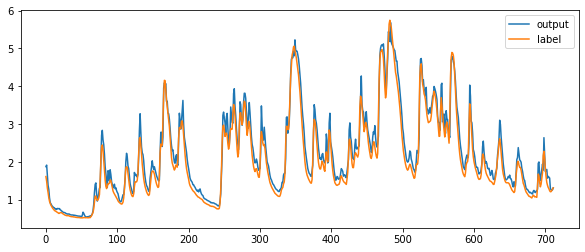

RMSE : 0.24716399610042572


In [6]:
# first step prediction result

fig = plt.figure(figsize=(10, 4))
plt.plot(output[0], label="output")
plt.plot(label[0], label="label")
plt.legend()
plt.show()

label1 = np.array(label[0])
output1 = np.array(output[0])

rmse = np.sqrt(np.mean((label1 - output1)**2))
print(f"RMSE : {rmse}")

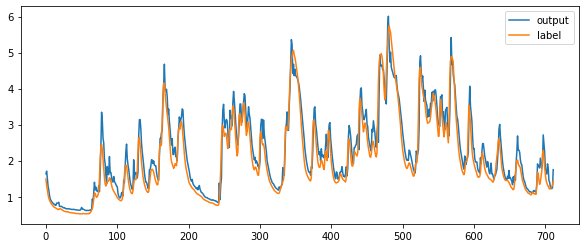

RMSE : 0.3340841233730316


In [7]:
# second step prediction result

fig = plt.figure(figsize=(10, 4))
plt.plot(output[1], label="output")
plt.plot(label[1], label="label")
plt.legend()
plt.show()

label2 = np.array(label[1])
output2 = np.array(output[1])

rmse = np.sqrt(np.mean((label2 - output2)**2))
print(f"RMSE : {rmse}")

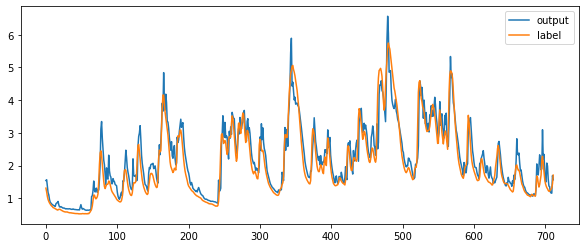

RMSE : 0.3713673949241638


In [8]:
# third step prediction result

fig = plt.figure(figsize=(10, 4))
plt.plot(output[2], label="output")
plt.plot(label[2], label="label")
plt.legend()
plt.show()

label3 = np.array(label[2])
output3 = np.array(output[2])

rmse = np.sqrt(np.mean((label3 - output3)**2))
print(f"RMSE : {rmse}")

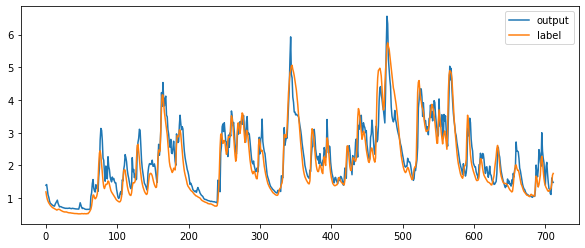

RMSE : 0.4034759998321533


In [9]:
# fourth step prediction result

fig = plt.figure(figsize=(10, 4))
plt.plot(output[3], label="output")
plt.plot(label[3], label="label")
plt.legend()
plt.show()

label4 = np.array(label[3])
output4 = np.array(output[3])

rmse = np.sqrt(np.mean((label4 - output4)**2))
print(f"RMSE : {rmse}")